Importing Libraries

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

Importing Dataset

In [79]:
df=pd.read_excel("/kaggle/input/flight-fare-prediction-mh/Data_Train.xlsx")
df
df2=df

PreProcessing

In [80]:
df["Additional_Info"].unique()
#layover=sosta
#red-eye flight refers to a flight that departs at night and arrives the next morning
#attention to business class
#no info together

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [81]:
#airline inconsistency
df["Airline"]=df["Airline"].str.replace("Vistara Premium economy","Vistara")
df["Airline"]=df["Airline"].str.replace("Jet Airways Business","Jet Airways")
df["Airline"]=df["Airline"].str.replace("Multiple carriers Premium economy","Multiple carriers")

In [82]:
#destination inconsistency
df["Destination"]=df["Destination"].str.replace("New Delhi","Delhi")

In [83]:
#total stop inconsistency
dict={'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}
df['Total_Stops']=df['Total_Stops'].map(dict)#layover in additional info can be redundant, we need to check
df2["Total_Stops"]=df["Total_Stops"]
df["Total_Stops"]

0        0.0
1        2.0
2        2.0
3        1.0
4        1.0
        ... 
10678    0.0
10679    0.0
10680    0.0
10681    0.0
10682    2.0
Name: Total_Stops, Length: 10683, dtype: float64

In [84]:
#missing values
df.isnull().sum().to_frame().rename(columns={0:"missing_values_count"}).T 
#imputation
df["Route"].fillna(df["Route"].mode()[0],inplace=True)


In [85]:
duration=list(df['Duration'])
for i in range(len(duration)):
    if len(duration[i].split(' '))==2:
        pass
    else:
        if 'h' in duration[i]: # Check if duration contains only hour
             duration[i]=duration[i] + ' 0m' # Adds 0 minute
        else:
             duration[i]='0h '+ duration[i]
df['Duration']=duration
def hour(x):
    return x.split(' ')[0][0:-1]

def minutes(x):
    return x.split(' ')[1][0:-1]
df['dur_hour']=df['Duration'].apply(hour)
df['dur_min']=df['Duration'].apply(minutes)
df['dur_hour'] = df['dur_hour'].astype(int)
df['dur_min'] = df['dur_min'].astype(int)
df.drop(columns=['Duration'], inplace=True)


In [86]:
#max number of route segments
max_route_segments = max(df['Route'].str.count('→')) + 1

# Create 'Route' columns
for i in range(1, max_route_segments + 1):
    df[f'Route{i}'] = df['Route'].str.split('→').str[i - 1]

# Create dummy variables for 'Airline', 'Source', and 'Destination'
airline_dummies = pd.get_dummies(df['Airline'], prefix='Airline', drop_first=True)
source_dummies = pd.get_dummies(df['Source'], prefix='Source', drop_first=True)
destination_dummies = pd.get_dummies(df['Destination'], prefix='Destination', drop_first=True)

# Concatenate the original Df with the dummy variables and the new Route columns
df = pd.concat([df, airline_dummies, source_dummies, destination_dummies], axis=1)

# Drop the original categorical columns
df.drop(['Airline', 'Source', 'Destination', 'Route'], axis=1, inplace=True)


In [87]:
for i in ['Route3', 'Route4', 'Route5','Route6']:
    df[i].fillna('None',inplace=True)

In [88]:
df.isnull().sum()
#no missing values

Date_of_Journey              0
Dep_Time                     0
Arrival_Time                 0
Total_Stops                  1
Additional_Info              0
Price                        0
dur_hour                     0
dur_min                      0
Route1                       0
Route2                       0
Route3                       0
Route4                       0
Route5                       0
Route6                       0
Airline_Air India            0
Airline_GoAir                0
Airline_IndiGo               0
Airline_Jet Airways          0
Airline_Multiple carriers    0
Airline_SpiceJet             0
Airline_Trujet               0
Airline_Vistara              0
Source_Chennai               0
Source_Delhi                 0
Source_Kolkata               0
Source_Mumbai                0
Destination_Cochin           0
Destination_Delhi            0
Destination_Hyderabad        0
Destination_Kolkata          0
dtype: int64

In [89]:
#I decided to use LabelEncoder to transform the categorical value into dummies
#I prefer this method over OneHotEncoding because I don't want to give an ordinal value to my variables so that the algorithm don't misunderstand
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for i in ['Route1', 'Route2', 'Route3', 'Route4', 'Route5','Route6']:
    df[i]=encoder.fit_transform(df[i])


In [90]:
df.drop(columns=['Additional_Info'], inplace=True)
#I decided to just drop it, it's easier and the info are mostly not really usefull and redundant

In [91]:
df
#everything seams allright, we can pass to the next phase

,Date_of_Journey,Dep_Time,Arrival_Time,Total_Stops,Price,dur_hour,dur_min,Route1,Route2,Route3,...,Airline_Trujet,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,24/03/2019,22:20,01:10 22 Mar,0.0,3897,2,50,0,13,29,...,False,False,False,False,False,False,False,True,False,False
1,1/05/2019,05:50,13:15,2.0,7662,7,25,2,25,1,...,False,False,False,False,True,False,False,False,False,False
2,9/06/2019,09:25,04:25 10 Jun,2.0,13882,19,0,3,32,4,...,False,False,False,True,False,False,True,False,False,False
3,12/05/2019,18:05,23:30,1.0,6218,5,25,2,34,3,...,False,False,False,False,True,False,False,False,False,False
4,01/03/2019,16:50,21:35,1.0,13302,4,45,0,34,8,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,9/04/2019,19:55,22:25,0.0,4107,2,30,2,5,29,...,False,False,False,False,True,False,False,False,False,False
10679,27/04/2019,20:45,23:20,0.0,4145,2,35,2,5,29,...,False,False,False,False,True,False,False,False,False,False
10680,27/04/2019,08:20,11:20,0.0,7229,3,0,0,13,29,...,False,False,False,False,False,False,False,True,False,False
10681,01/03/2019,11:30,14:10,0.0,12648,2,40,0,13,29,...,False,True,False,False,False,False,False,True,False,False


EDA PHASE

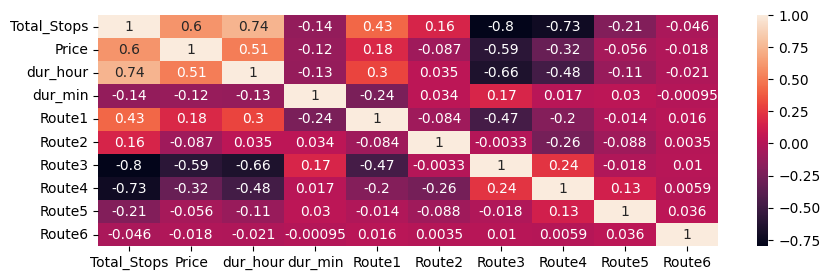

In [92]:
#correlation
numerical_df = df.select_dtypes(include='number')
plt.figure(figsize=(10,3))
sns.heatmap(numerical_df.corr(),annot=True);
#i found some interesting correlation but I was looking mostly for high correlated variables, in this case I didn't find any

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


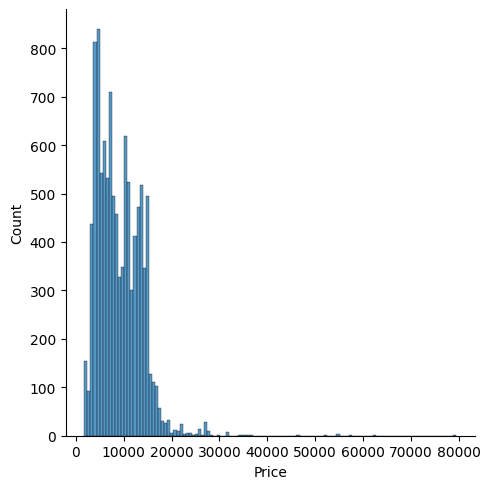

In [93]:
#our target price
sns.displot(x="Price",data=df);
#the skewness tell us that we have more flight with low price, the one with high price seams outliers

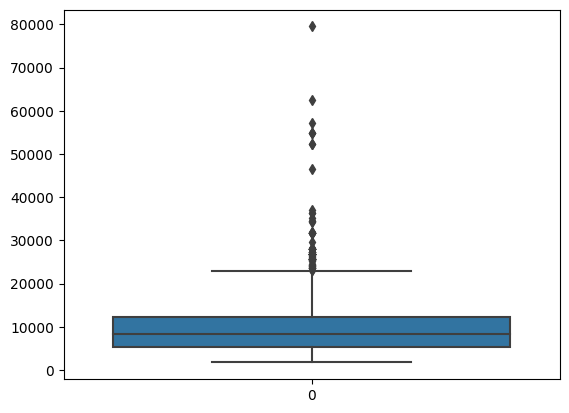

In [94]:
#let's check the outliers trough a boxplot
sns.boxplot(df["Price"]);

In [95]:
#let's analize the flight company
df2["Airline"].value_counts()

Airline
Jet Airways          3855
IndiGo               2053
Air India            1752
Multiple carriers    1209
SpiceJet              818
Vistara               482
Air Asia              319
GoAir                 194
Trujet                  1
Name: count, dtype: int64

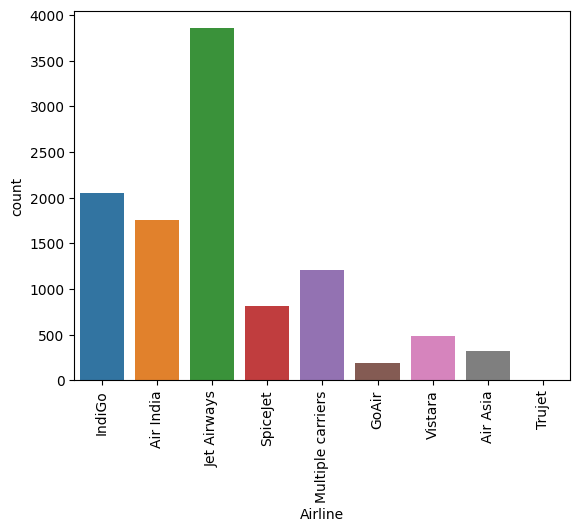

In [96]:
sns.countplot(x="Airline",data=df2)
plt.xticks(rotation=90);

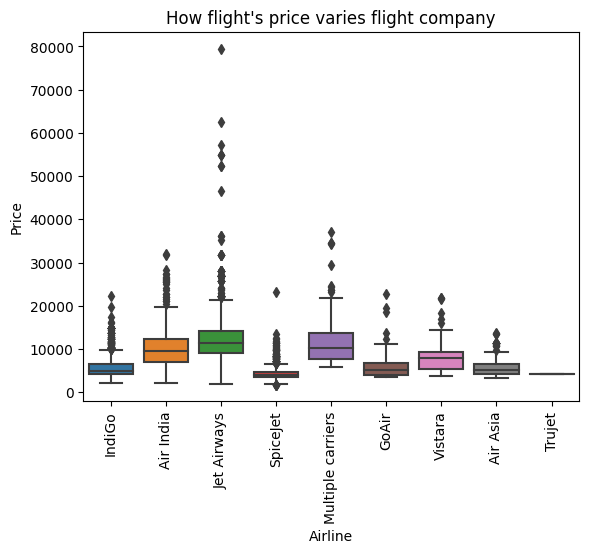

In [97]:
sns.boxplot(x="Airline",y="Price",data=df2)
plt.xticks(rotation=90)
plt.title("How flight's price varies flight company");

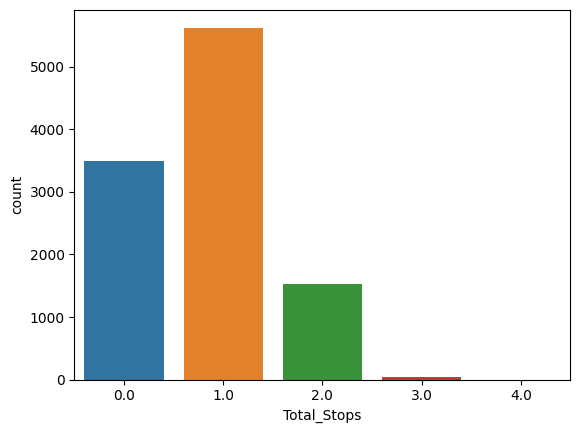

In [98]:
#total stops
sns.countplot(x="Total_Stops",data=df2);

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'IndiGo'),
  Text(1, 0, 'Air India'),
  Text(2, 0, 'Jet Airways'),
  Text(3, 0, 'SpiceJet'),
  Text(4, 0, 'Multiple carriers'),
  Text(5, 0, 'GoAir'),
  Text(6, 0, 'Vistara'),
  Text(7, 0, 'Air Asia'),
  Text(8, 0, 'Trujet')])

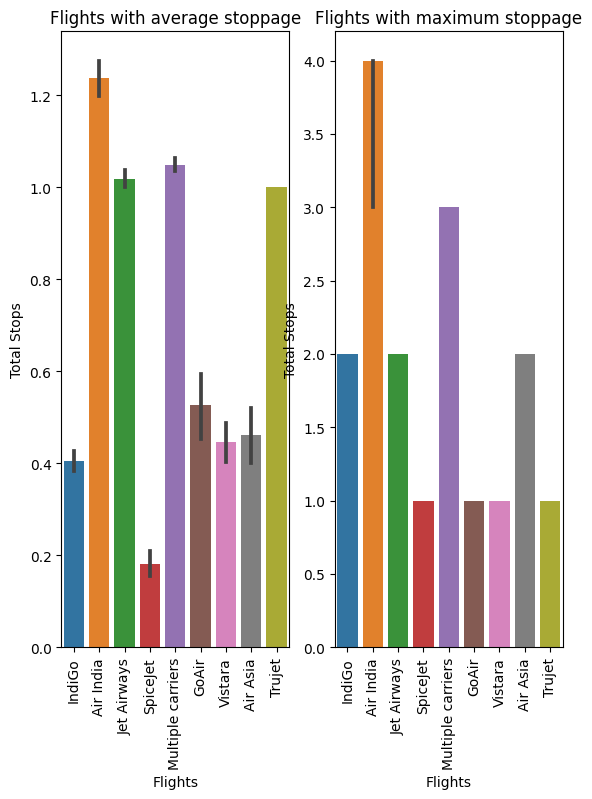

In [99]:
#checking the relations between Company and number of stops
plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
sns.barplot(x="Airline",y="Total_Stops",data=df2)
plt.title("Flights with average stoppage")
plt.xlabel("Flights")
plt.ylabel("Total Stops")
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.barplot(x="Airline",y="Total_Stops",data=df2,estimator=max)
plt.title("Flights with maximum stoppage")
plt.xlabel("Flights")
plt.ylabel("Total Stops")
plt.xticks(rotation=90)
#taking into account that a bigger number of stops usually involves bigger distance flight we can understand which company mostly handle international flights
#Additionaly,having more stops means also a lower price, so we can even understand the low budget company

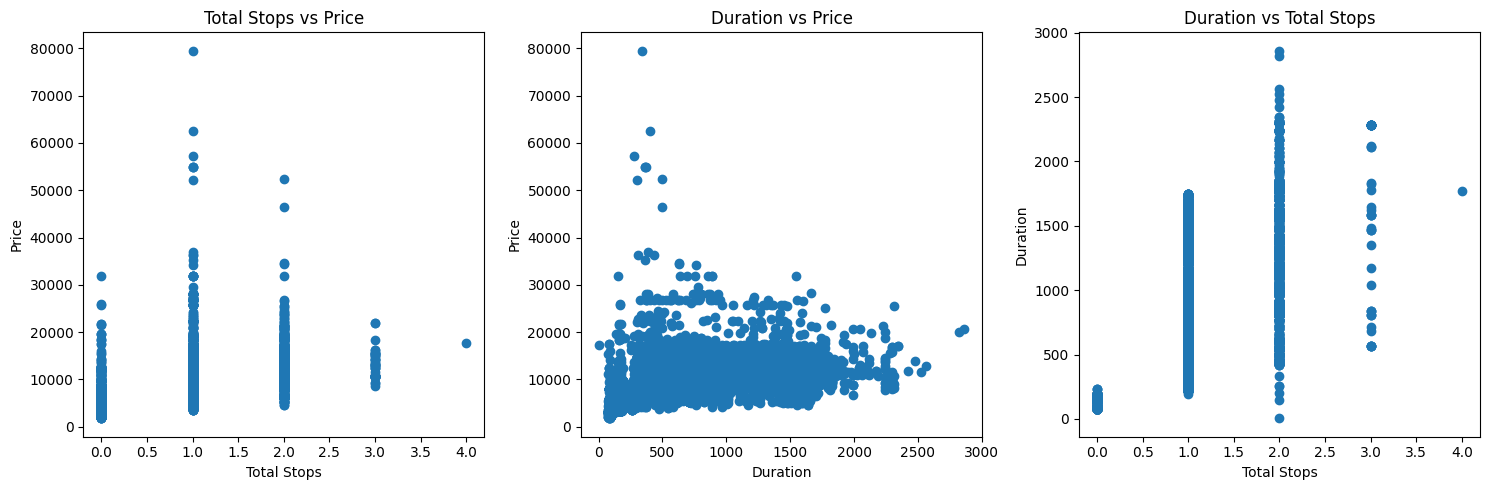

In [100]:
# Combine dur_hour and dur_min to create a Duration column in minutes
df2["Duration"] = df2["dur_hour"] * 60 + df2["dur_min"]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(df2["Total_Stops"], df2["Price"])
plt.title("Total Stops vs Price")
plt.xlabel("Total Stops")
plt.ylabel("Price")

plt.subplot(1, 3, 2)
plt.scatter(df2["Duration"], df2["Price"])
plt.title("Duration vs Price")
plt.xlabel("Duration")
plt.ylabel("Price")

plt.subplot(1, 3, 3)
plt.scatter(df2["Total_Stops"], df2["Duration"])
plt.title("Duration vs Total Stops")
plt.xlabel("Total Stops")
plt.ylabel("Duration")

plt.tight_layout()
plt.show()
#the relation between total stop and price confirm what we said before
#in duration vs price we can see some outliers, probably this are business class

In [101]:
#price for different flight from source to destination
k=df2.groupby(["Source","Destination","Airline"])["Price"].agg(["mean","max","min"])
k.reset_index(inplace=True)
k

,Source,Destination,Airline,mean,max,min
0,Banglore,Delhi,Air Asia,4574.280899,10873,3383
1,Banglore,Delhi,Air India,9238.198795,31783,3758
2,Banglore,Delhi,GoAir,4948.881720,18558,3398
3,Banglore,Delhi,IndiGo,5274.112811,22153,3359
4,Banglore,Delhi,Jet Airways,11283.462121,79512,3359
5,Banglore,Delhi,SpiceJet,4550.292818,23267,3257
6,Banglore,Delhi,Vistara,6211.037433,21730,4353
7,Chennai,Kolkata,Air India,5895.640000,19630,3145
8,Chennai,Kolkata,IndiGo,4538.766304,8580,3384
9,Chennai,Kolkata,SpiceJet,3993.523438,7718,3332


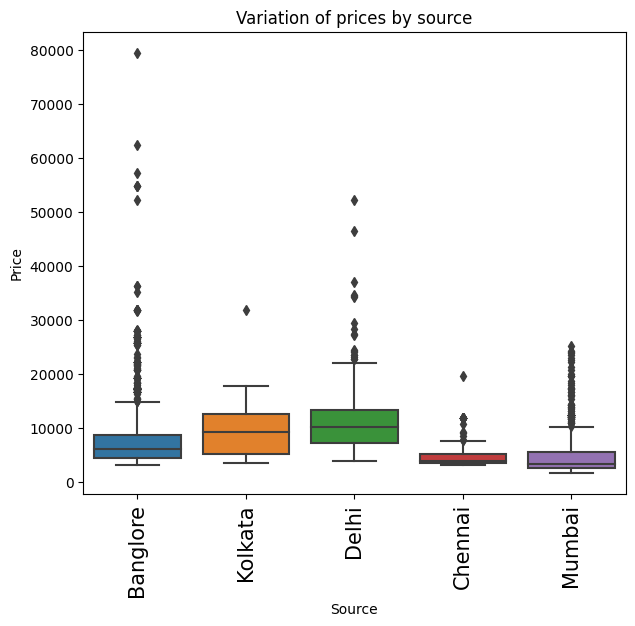

In [102]:
#how price varies from source
plt.figure(figsize=(7,6))
sns.boxplot(x="Source",y="Price",data=df2)
plt.xticks(rotation=90,size=15)
plt.title("Variation of prices by source")
plt.show()

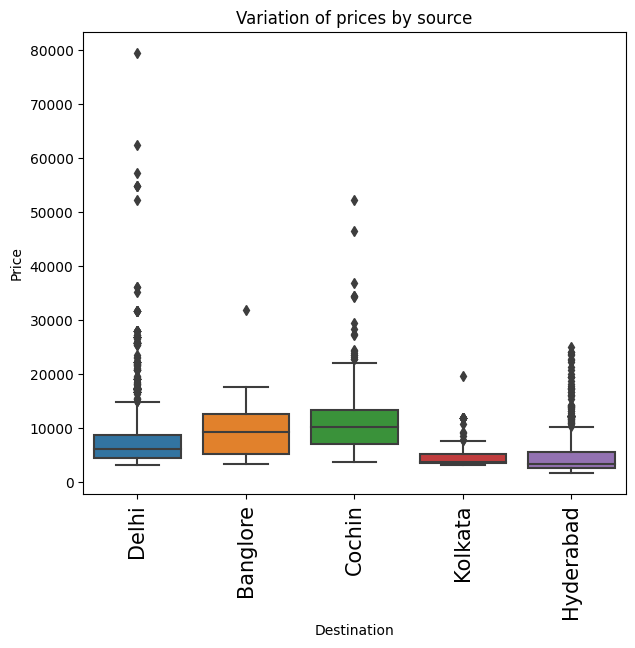

In [103]:
#how price varies from destination
plt.figure(figsize=(7,6))
sns.boxplot(x="Destination",y="Price",data=df2)
plt.xticks(rotation=90,size=15)
plt.title("Variation of prices by source")
plt.show()

In [104]:
# Assuming 'date_column' is the name of your date column
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])  # Convert to datetime
df['year'] = df['Date_of_Journey'].dt.year  # Extract year as a numeric feature
df['month'] = df['Date_of_Journey'].dt.month  # Extract month as a numeric feature
df['day'] = df['Date_of_Journey'].dt.day  # Extract day as a numeric feature
df = df.drop('Date_of_Journey', axis=1)  # Drop the original date column
df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.hour * 60 + pd.to_datetime(df['Dep_Time']).dt.minute
def convert_arrival_time(arrival_time_str):
    try:
        # Handle different time formats
        time_obj = pd.to_datetime(arrival_time_str, format='%H:%M')
    except ValueError:
        time_obj = pd.to_datetime(arrival_time_str, format='%H:%M %d %b')

    return time_obj.hour * 60 + time_obj.minute

df['Arrival_Time'] =df['Arrival_Time'].apply(convert_arrival_time)

/tmp/ipykernel_32/1302202927.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])  # Convert to datetime
/tmp/ipykernel_32/1302202927.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.hour * 60 + pd.to_datetime(df['Dep_Time']).dt.minute
/tmp/ipykernel_32/1302202927.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.hour * 60 + pd.to_datetime(df['Dep_Time']).dt.minute


<Axes: xlabel='month', ylabel='count'>

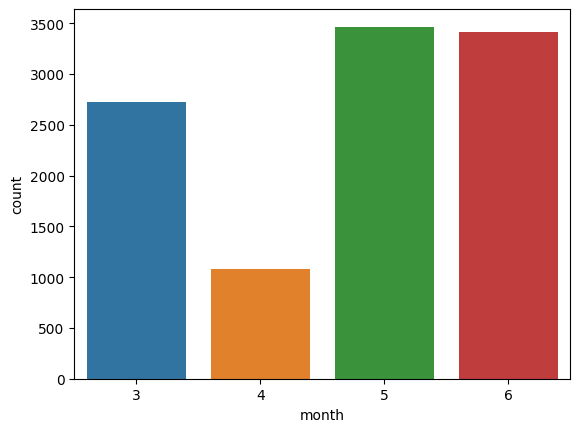

In [105]:
#busiest month
sns.countplot(x="month",data=df)

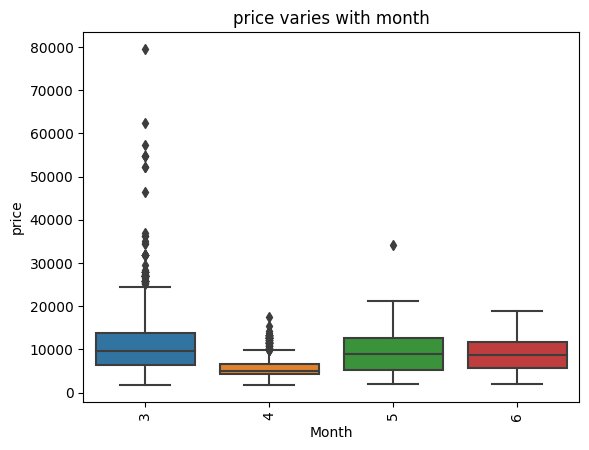

In [106]:
sns.boxplot(x="month",y="Price",data=df)
plt.xticks(rotation=90);
plt.ylabel("price")
plt.xlabel("Month")
plt.title("price varies with month");

Preparing for our model

In [107]:
#handling outliers
df['Price']=np.where(df['Price']>=40000,df['Price'].median(),df['Price'])

In [108]:
X=df.drop('Price',axis=1)
y=df['Price']

In [ ]:
X.fillna(X.mean(), inplace=True)

imp = pd.DataFrame(mutual_info_classif(X,y),index=X.columns)
imp.columns=['importance']
imp.sort_values(by='importance',ascending=False)
#we sorted the variables in our dataset by importance, i think it's useless to remove the last variable from the dataset because is the only value with that company

Model

In [ ]:
# spiliting the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=123)

We are gonna try some model and test it through three regression metric.
The goal is to choose which is more or less the best performing model to focus on it later

In [ ]:
#we define our function to test the model and print us the metric
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
def predict(ml_model):
    print('Model is: {}'.format(ml_model))
    model= ml_model.fit(X_train,y_train)
    print("Training score: {}".format(model.score(X_train,y_train)))
    predictions = model.predict(X_test)
    print("Predictions are: {}".format(predictions))
    print('\n')
    r2score=r2_score(y_test,predictions) 
    print("r2 score is: {}".format(r2score))
          
    print('MAE:{}'.format(mean_absolute_error(y_test,predictions)))
    print('MSE:{}'.format(mean_squared_error(y_test,predictions)))
    print('RMSE:{}'.format(np.sqrt(mean_squared_error(y_test,predictions))))
     
    sns.distplot(y_test-predictions)      

Importing the libraries we need

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor  # For regression tasks

Random Forest

In [ ]:
predict(RandomForestRegressor())

Model is: RandomForestRegressor()
Training score: 0.9528337148077749
Predictions are: [ 3618.83        4171.57666667  2707.182      ... 10639.44166667
  9650.46566667  7436.89033333]


r2 score is: 0.7918842300392406
MAE:1147.9335604026426
MSE:3879262.537899316
RMSE:1969.5843566344945

Logistic Regression

In [ ]:
predict(LogisticRegression())


Training score: 0.05721975193072783
Predictions are: [ 7229.  4804.  7229. ... 10262. 10844.  4804.]


r2 score is: 0.01096784746709134
MAE:3099.2550304164715
MSE:18435486.070191856
RMSE:4293.656491871684

KKN

In [ ]:
predict(KNeighborsRegressor())


Model is: KNeighborsRegressor()
Training score: 0.7446717009265098
Predictions are: [ 4294.   4790.4  3100.  ... 11542.2  9851.8  5917.6]


r2 score is: 0.5988180858946603
MAE:1717.9731399157697
MSE:7478001.165240992
RMSE:2734.593418634842

Light GBM

In [ ]:
predict(LGBMRegressor())


Model is: LGBMRegressor()
Training score: 0.8895370213687149
Predictions are: [ 4329.44020829  4324.48390375  2829.17735366 ... 11348.69627823
 10461.88527155  6578.3988191 ]


r2 score is: 0.8260262241569951
MAE:1177.18226199447
MSE:3242858.2962834253
RMSE:1800.7937961586344

LightGBM is the best performing model, i'm gonna improve it tuning the hyperparameters

In [ ]:
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
param_grid = {
    'num_leaves': [20, 30, 40],  
    'learning_rate': [0.05, 0.1, 0.2, 0.01],  
    'max_depth': [5, 10, 15], 
    'min_child_samples': [10, 20, 30],
}


In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor()
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='r2', cv=5, verbose=1)
grid_search.fit(X_train, y_train)


In [ ]:
best_lgb_model = grid_search.best_estimator_
y_pred = best_lgb_model.predict(X_val)

from sklearn.metrics import r2_score

r2score = r2_score(y_val, y_pred)


In [ ]:
final_lgb_model = lgb.LGBMRegressor(**grid_search.best_params_)
final_lgb_model.fit(X, y)


In [ ]:
r2score
#the model is performing really good and tuning the hyperparameters give us a better score